In [3]:
import functools
import pickle as pkl

import numpy as np
import pandas as pd
import torch
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils/')
from data import TacoText
from preprocess import load_data, clean_and_tokenize
from pipeline import pipeline

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import log_loss
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

%matplotlib inline

In [2]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data.reindex(np.random.permutation(train_data.index))
val_data = train_data.iloc[int(len(train_data) * 0.9):]
train_data = train_data.iloc[:int(len(train_data) * 0.9)]

In [12]:
pipe = functools.partial(pipeline, 
                        rm_stop_words=1, 
                        rm_punc=True, 
                        number_token=True, 
                        keep_questions=True,
                        stemmer=None,
                        lemmatizer=None)

In [62]:
pipe = functools.partial(pipeline, 
                        rm_stop_words=0, 
                        rm_punc=False, 
                        number_token=False, 
                        keep_questions=True,
                        stemmer=None,
                        lemmatizer=None)

In [65]:
pipe = None

In [13]:
corpus = TacoText(50000, lower=True, vocab_pipe=pipe)

In [6]:
q1, q2, y = clean_and_tokenize(train_data, corpus)

In [7]:
q1_val, q2_val, y_val = clean_and_tokenize(val_data, corpus)

* WC1
* WC2
* abs(WC1-WC2)
* num_words in common
* jaccard_similarity
* w1 pct overlap
* w2 pct overlap
* Num Stop Words
* start word Who, What, When, Where, Why, How, Which

In [94]:
def feature_gen(x, stopwords):
    f = []
    f.append(abs(len(x[0]) - len(x[1])))  #WCDifference
    wic = set(x[0]).intersection(set(x[1]))
    uw = set(x[0]).union(set(x[1]))
    
    wic_sw = len([w for w in wic if w not in stopwords])
    uw_sw = len([w for w in uw if w not in stopwords])
    if uw_sw < 1:
        uw_sw = 0
    f.append(wic_sw/uw_sw)
    
    uw = len(uw)
    wic = len(wic)
    f.append(wic) #NumWordsInCommon
    f.append(uw) #Num unique words
    f.append(wic/uw) #Jaccard
    f.append(f[3]/len(set(x[0])))  #Pct Overlap Q1
    f.append(int((f[3]/len(set(x[0]))) < 0.1))
    f.append(int((f[3]/len(set(x[0]))) < 0.2))
    f.append(int((f[3]/len(set(x[0]))) < 0.3))
    f.append(int((f[3]/len(set(x[0]))) < 0.4))
    f.append(int((f[3]/len(set(x[0]))) < 0.5))
    f.append(f[3]/len(set(x[1])))  #Pct Overlap Q2
    f.append(int((f[3]/len(set(x[1]))) < 0.1))
    f.append(int((f[3]/len(set(x[1]))) < 0.2))
    f.append(int((f[3]/len(set(x[1]))) < 0.3))
    f.append(int((f[3]/len(set(x[1]))) < 0.4))
    f.append(int((f[3]/len(set(x[1]))) < 0.5))
    f.append(int((wic/uw) < 0.1))
    f.append(int((wic/uw) < 0.2))
    f.append(int((wic/uw) < 0.3))
    f.append(int((wic/uw) < 0.4))
    f.append(int((wic/uw) < 0.5))
    f.append(int(x[0][0].lower() == x[1][0].lower()))
#     for q in ('who','what','when','where','why','how','which'):
#         f.append(int(x[0][0].lower() == q))
#         f.append(int(x[1][0].lower() == q))
    return f

In [95]:
# cols = ('WC1','WC2',
cols = ('WCDiff','NumCommon','Unique','Jaccard','pctOverlap1','pct1_01','pct1_02','pct1_03','pct1_04',
        'pct1_05','pctOverlap2','pct2_01','pct2_02','pct2_03','pct2_04','pct2_05','jac01',
        'jac02','jac03','jac04','jac05','same_start')
        #,'who1','who2','what1','what2','when1','when2','where1','where2','why1','why2','how1','how2','which1','which2')

In [69]:
train_X = list(map(feature_gen, zip(q1, q2)))
val_X = list(map(feature_gen, zip(q1_val, q2_val)))

In [76]:
scalar = preprocessing.StandardScaler()
train_X = scalar.fit_transform(train_X)
val_X = scalar.transform(val_X)

In [82]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [1]:
rclf = RandomForestClassifier(random_state=42)
rclf.fit(train_X, y)

print(rclf.score(train_X, y))
print(rclf.score(val_X, y_val))

NameError: name 'RandomForestClassifier' is not defined

In [94]:
1-(sum(y_val)/len(y_val))

0.62996858690543922

In [96]:
X_train2 = list(map(feature_gen, zip(q1, q2)))
X_val2 = list(map(feature_gen, zip(q1_val, q2_val)))

In [97]:
scalar = preprocessing.StandardScaler()
X_train2 = scalar.fit_transform(X_train2)
X_val2 = scalar.transform(X_val2)

In [100]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train2, y)

print(clf.score(X_train2, y))
print(clf.score(X_val2, y_val))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [103]:
rclf = RandomForestClassifier(random_state=42)
rclf.fit(X_train2, y)

print(rclf.score(X_train2, y))
print(rclf.score(X_val2, y_val))

0.73069936047
0.693240000989


In [20]:
X_train3 = list(map(feature_gen, zip(q1, q2)))
X_val3 = list(map(feature_gen, zip(q1_val, q2_val)))

scalar = preprocessing.StandardScaler()
X_train3 = scalar.fit_transform(X_train3)
X_val3 = scalar.transform(X_val3)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train3, y)

print(clf.score(X_train3, y))
print(clf.score(X_val3, y_val))

print(log_loss(y, clf.predict_proba(X_train3)))
print(log_loss(y_val, clf.predict_proba(X_val3)))

In [110]:
rclf = RandomForestClassifier(random_state=42)
rclf.fit(X_train3, y)

print(rclf.score(X_train3, y))
print(rclf.score(X_val3, y_val))

print(log_loss(y, rclf.predict_proba(X_train3)))
print(log_loss(y_val, rclf.predict_proba(X_val3)))

0.799783433784
0.705434218012


In [ ]:
svm = SVC()
svm.fit(X_train3, y)

In [ ]:
print(svm.score(X_train3, y))
print(svm.score(X_val3, y_val))

In [96]:
X_train3 = list(map(feature_gen, zip(q1, q2)))
X_val3 = list(map(feature_gen, zip(q1_val, q2_val)))

In [89]:
scalar = preprocessing.StandardScaler()
X_train3 = scalar.fit_transform(X_train3)
X_val3 = scalar.transform(X_val3)

In [104]:
np.max([1,2])

2

In [99]:
df = pd.DataFrame(data=X_train3, columns=cols)
df['y'] = y

In [105]:
import torch

In [110]:
X = torch.Tensor(5, 1, 2, 10).long()

In [121]:
a = np.array([1,2,3])
a = torch.from_numpy(a)
X[0,0,0,:3] = a

RuntimeError: inconsistent tensor size at /Users/soumith/miniconda2/conda-bld/pytorch_1490983738462/work/torch/lib/TH/generic/THTensorCopy.c:50

In [123]:
np.array([[1,2,3],[4,5,6]]).shape

(2, 3)

In [97]:
cols

('WCDiff',
 'NumCommon',
 'Unique',
 'Jaccard',
 'pctOverlap1',
 'pct1_01',
 'pct1_02',
 'pct1_03',
 'pct1_04',
 'pct1_05',
 'pctOverlap2',
 'pct2_01',
 'pct2_02',
 'pct2_03',
 'pct2_04',
 'pct2_05',
 'jac01',
 'jac02',
 'jac03',
 'jac04',
 'jac05',
 'same_start')

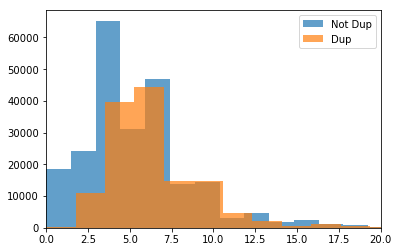

In [88]:
plt.hist(df[(df['y'] == 0)]['NumCommon'], bins=25, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['NumCommon'], bins=25, label='Dup', alpha=0.7)
plt.xlim(0,20)
plt.legend()

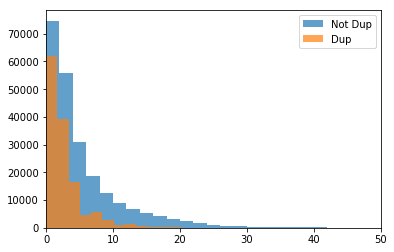

In [61]:
plt.hist(df[(df['y'] == 0) & (df['WCDiff'] <= 50)]['WCDiff'], bins=25, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['WCDiff'], bins=25, label='Dup', alpha=0.7)
plt.xlim(0,50)
plt.legend()

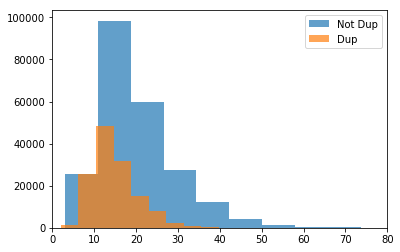

In [65]:
plt.hist(df[(df['y'] == 0)]['Unique'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['Unique'], bins=20, label='Dup', alpha=0.7)
plt.xlim(0,80)
plt.legend()

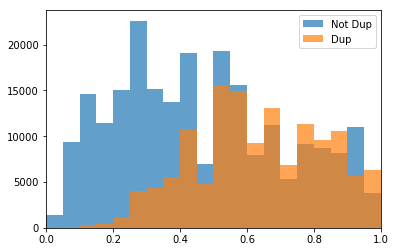

In [67]:
plt.hist(df[(df['y'] == 0)]['pctOverlap1'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['pctOverlap1'], bins=20, label='Dup', alpha=0.7)
plt.xlim(0,1)
plt.legend()

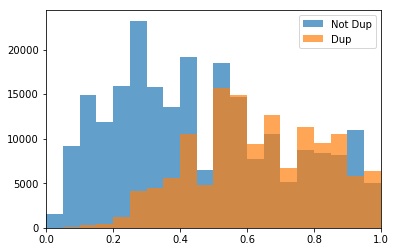

In [68]:
plt.hist(df[(df['y'] == 0)]['pctOverlap2'], bins=20, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['pctOverlap2'], bins=20, label='Dup', alpha=0.7)
plt.xlim(0,1)
plt.legend()

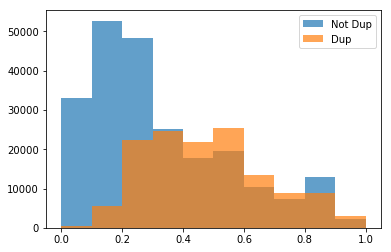

In [62]:
plt.hist(df[(df['y'] == 0)]['Jaccard'], bins=10, label='Not Dup', alpha=0.7)
plt.hist(df[df['y'] == 1]['Jaccard'], bins=10, label='Dup', alpha=0.7)
plt.legend()

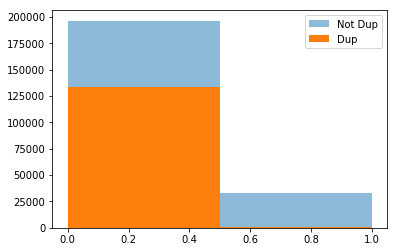

In [81]:
plt.hist(df[(df['y'] == 0)]['jac01'], bins=2, label='Not Dup', alpha=0.5)
plt.hist(df[df['y'] == 1]['jac01'], bins=2, label='Dup', alpha=1.0)
plt.legend()

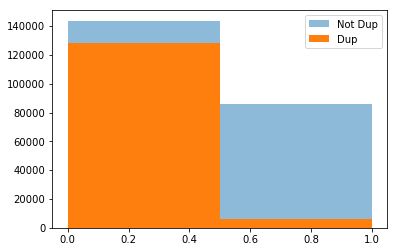

In [82]:
plt.hist(df[(df['y'] == 0)]['jac02'], bins=2, label='Not Dup', alpha=0.5)
plt.hist(df[df['y'] == 1]['jac02'], bins=2, label='Dup', alpha=1.0)
plt.legend()

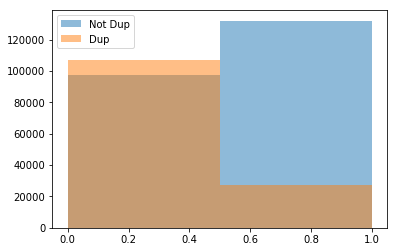

In [84]:
plt.hist(df[(df['y'] == 0)]['jac03'], bins=2, label='Not Dup', alpha=0.5)
plt.hist(df[df['y'] == 1]['jac03'], bins=2, label='Dup', alpha=0.5)
plt.legend()

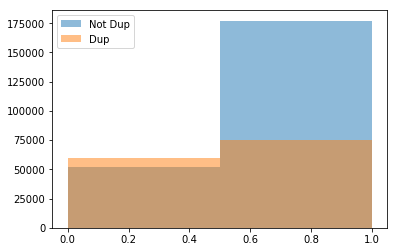

In [85]:
plt.hist(df[(df['y'] == 0)]['jac05'], bins=2, label='Not Dup', alpha=0.5)
plt.hist(df[df['y'] == 1]['jac05'], bins=2, label='Dup', alpha=0.5)
plt.legend()

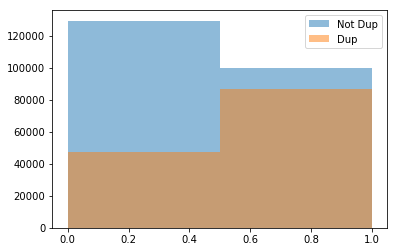

In [100]:
plt.hist(df[(df['y'] == 0)]['same_start'], bins=2, label='Not Dup', alpha=0.5)
plt.hist(df[df['y'] == 1]['same_start'], bins=2, label='Dup', alpha=0.5)
plt.legend()

In [90]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train3, y)

print(clf.score(X_train3, y))
print(clf.score(X_val3, y_val))

print(log_loss(y, clf.predict_proba(X_train3)))
print(log_loss(y_val, clf.predict_proba(X_val3)))

0.785618684058
0.691582774741
0.374922659765
3.29357281779


In [91]:
clf.feature_importances_

array([  1.53723179e-01,   4.19405715e-02,   2.53489532e-02,
         4.06853810e-01,   1.09455112e-01,   4.51341605e-04,
         1.42542582e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.47660952e-02,   4.50297335e-04,
         1.14056844e-05,   0.00000000e+00,   0.00000000e+00,
         1.76628648e-05,   4.53251835e-05,   5.61383691e-04,
         3.45947533e-04,   8.92942358e-04,   8.26063042e-04,
         7.80149486e-03,   6.54179849e-03,   1.59002428e-02,
         2.63260633e-02,   5.41454066e-03,   5.40694949e-03,
         5.78457181e-03,   5.69287223e-03,   1.33830719e-02,
         1.20781213e-02,   2.03241514e-02,   1.71487210e-02,
         1.08768255e-02,   1.14879416e-02])

In [93]:
rclf = RandomForestClassifier(random_state=42)
rclf.fit(X_train3, y)

print(rclf.score(X_train3, y))
print(rclf.score(X_val3, y_val))

print(log_loss(y, rclf.predict_proba(X_train3)))
print(log_loss(y_val, rclf.predict_proba(X_val3)))

0.781040012532
0.695664003562
0.404143657009
10.5115222175


In [101]:
rclf = RandomForestClassifier(random_state=42)
rclf.fit(X_train3, y)

print(rclf.score(X_train3, y))
print(rclf.score(X_val3, y_val))

print(log_loss(y, rclf.predict_proba(X_train3)))
print(log_loss(y_val, rclf.predict_proba(X_val3)))

0.723633475421
0.685918523832
0.484656994668
0.82847578128


In [25]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train3, y)

print(clf.score(X_train3, y))
print(clf.score(X_val3, y_val))

print(log_loss(y, clf.predict_proba(X_train3)))
print(log_loss(y_val, clf.predict_proba(X_val3)))

0.800827788634
0.692497959386
0.348244424774
3.81989459392


In [199]:
a = torch.from_numpy(np.array([[1,2,3,4.0],[5,6,9,8],[5,6,7,8]]))
b = torch.from_numpy(np.array([[0,1,2,3.0],[7,2,9,-10], [5,6,7,8]]))

In [206]:
from torch.autograd import Variable

In [207]:
a = Variable(a)
b = Variable(b)

In [210]:
def distances(x1, x2):
    dim1, dim2 = x1.size()
    
    cos_dis = Variable(torch.Tensor(dim1, 1).float())
    for d in range(dim1):
        norm = (torch.norm(x1[d], 2) * torch.norm(x2[d], 2))
        cos_dis[d] = torch.dot(x1[d], x2[d]) / norm
    
    sum_sq = (x1-x2).pow(2).sum(1).float()

    return torch.cat((cos_dis, sum_sq), 1)

In [174]:
cosine_similarity(a, b)


 0.9759
 0.1487
[torch.FloatTensor of size 2x1]

In [159]:
torch.dot(a[0], b[0]) / (torch.norm(a[0], p=2) * torch.norm(b[0], p=2))

-0.9759000729485332

In [205]:
torch.norm(a[0], 2) * torch.norm(b[0], 2)

20.493901531919196

In [178]:
(a-b).pow(2).sum(1)


   4
 348
[torch.DoubleTensor of size 2x1]

In [191]:
a.mul(b)


  0   2   6  12
 35  12  63 -80
[torch.DoubleTensor of size 2x4]

In [198]:
distances(a,b)

20.493901531919196
219.55409356238385



   0.0000    0.0976    0.2928    0.5855    0.9759    4.0000
   0.1594    0.0547    0.3689   -0.3644    0.2186  344.0000
[torch.FloatTensor of size 2x6]

In [213]:
distances(a,b)

Variable containing:
   0.9759    4.0000
   0.2186  344.0000
   1.0000    0.0000
[torch.FloatTensor of size 3x2]